In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import numpy 
from shapely.wkb import loads
from shapely.geometry import Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import openpyxl
import itertools
import networkx as nx
from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

# Define a helper function to generate pairs of consecutive elements in a list
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)
    
# Define a helper function to generate permutations
def permutations(iterable, r=None):
   # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return 
        
# Retrive data from OSM and get the geographic data of tram
def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 

def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    shapely_geo = shapely.from_wkt(feature.geometry().ExportToWkt())
                    if shapely_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(shapely_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}    
    
def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all railway linestrings.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])        

def tram_network(osm_path):
    """
    Extracts tram network data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing tram network data extracted from the OpenStreetMap file.
    """

    # Extract railway data from the OpenStreetMap file
    df_railway = railway(osm_path)
    
    # Filter the DataFrame to only contain tram network data
    tram = df_railway.loc[df_railway.railway == 'tram']
    
    # Return the filtered DataFrame
    return tram

def railway_stations(osm_path):
    """
    Function to extract tram station nodes from OpenStreetMap.  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all tram station nodes.
    """   
    
    return (retrieve(osm_path,'points',['public_transport', 'tram', 'name']))  #,'railway'

def tram_stations(osm_path):

    df_railway_stations = railway_stations(osm_path)
    
    tram_stations = df_railway_stations.loc[df_railway_stations.tram == 'yes']
    tram_stations = tram_stations.loc[tram_stations.public_transport == 'stop_position']
    
    return tram_stations

def routes(osm_path):
    """
    Extracts route data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing route data extracted from the OpenStreetMap file.
    """

    # Call the 'retrieve' function to extract route data from the OpenStreetMap file
    # The 'retrieve' function takes three arguments:
    # - The file path of the OpenStreetMap file
    # - A list of geometry types to extract (in this case, only multilinestrings)
    # - A list of tag keys to extract (in this case, 'route', 'name', and 'ref')
    route_data = retrieve(osm_path, 'multilinestrings', ['route', 'to', 'name', 'ref'])#,'from'])

    # Return the extracted route data as a Pandas DataFrame
    return route_data

def add_stations(net,station_file):
    
    station_geometries = pd.DataFrame(station_file.geometry)
    
    net.nodes = pd.concat([net.nodes,station_geometries]).reset_index(drop=True)
                           
    return net

# Pre-processing the geographic data of the subway network to obtain 'edges' and 'nodes'
def prepare_network(subway,station_file):
    """
    Prepare a subway network represented as a GeoDataFrame of LineString objects for routing.

    Args:
    - subway: a GeoDataFrame representing the subway network, with 'geometry' column containing LineString objects
    
    Returns:
    - a tuple of two DataFrames representing the edges and nodes of the prepared network

    Example:
    >>> import geopandas
    >>> subway = geopandas.read_file('subway.shp')
    >>> edges, nodes = prepare_network(subway)

    Note: This function requires the shapely, NetworkX, and Pandas libraries to be installed.
    """

    # Build a Network object from the subway edges
    net = Network(edges=subway)

    # Add endpoints to the network where edges don't intersect
    net = add_endpoints(net)
    
    # Add endpoints to the network where edges don't intersect
    net = add_stations(net,station_file)
        
    # Split edges at new endpoints
    net = split_edges_at_nodes(net)

    # Add new endpoints where edges were split
    net = add_endpoints(net)

    # Assign unique IDs to nodes and edges
    net = add_ids(net)

    # Add missing topology information to the network's edges
    net = add_topology(net)    

    # Calculate the degree of each node in the network
    net.nodes['degree'] = calculate_degree(net)

    # Merge edges with a degree of 2
    #net = merge_edges(net)

    # Drop duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # Reset node and edge IDs after fixing topology and merging edges
    net = reset_ids(net) 

    # Add edge distances
    net = add_distances(net)

    # Merge any MultiLineString edges
    net = merge_multilinestrings(net)

    # Add travel time for each edge based on distance and average speed
    net = add_travel_time(net)
    
    # Return the edges and nodes of the prepared network
    return net.edges, net.nodes

def expand_edges(edges):
    """
    Expand a DataFrame of edges into a format that can be used with network analysis algorithms.

    Args:
    - edges: a DataFrame containing edges with columns 'from_id', 'to_id', and 'distance'

    Returns:
    - a DataFrame containing expanded edges with columns 'from_id', 'to_id', 'distance', 'weights', 'to_from', and 'from_to'

    Example:
    >>> edges = pd.DataFrame({'from_id': [0, 0, 1], 'to_id': [1, 2, 2], 'distance': [1.5, 3.2, 2.8]})
    >>> expand_edges(edges)
      from_id  to_id  distance  weights  to_from  from_to
    0       0      1       1.5        1  (0, 1)  (1, 0)
    1       0      2       3.2        3  (0, 2)  (2, 0)
    2       1      2       2.8        2  (1, 2)  (2, 1)

    Notes:
    - The 'weights' column is created by rounding the 'distance' column to the nearest integer.
    - The 'to_from' and 'from_to' columns are created to facilitate conversion between edge formats.
    """
    # Round the distance to the nearest integer and store it in a new column 'weights'
    edges['weights'] = edges['distance'].astype(int)

    # Create 'to_from' and 'from_to' columns to facilitate conversion between edge formats
    edges['to_from'] = list(zip(edges.from_id, edges.to_id))
    edges['from_to'] = list(zip(edges.to_id, edges.from_id))

    # Return the expanded edges DataFrame
    return edges

In [3]:
def am_tram_stations(stations):
    
# Add columns for the x and y coordinates of each station
    stations['geo_x'] = stations.geometry.x
    stations['geo_y'] = stations.geometry.y
    
    # Drop duplicate stations and rename the two 'Centraal Station' stations as 'Centraal Station_A' and 'Centraal Station_B'
    sorted_stations = stations.sort_values(by='geo_x')
    stations_drop = sorted_stations[sorted_stations['name'] != 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
    station_cetralB = sorted_stations[sorted_stations['name'] == 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
    station_cetralB.iloc[0, 3] = 'Centraal Station_B'
    # station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
    station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
    station_cetralA = pd.DataFrame(station_cetralA)
    station_cetralA.iloc[0, 3] = 'Centraal Station_A'
    
    # Create DataFrames for the stations and concatenate them into one DataFrame
    df_stations_drop = pd.DataFrame(stations_drop)
    df_station_cetralB = pd.DataFrame(station_cetralB)
    df_station_cetralA = pd.DataFrame(station_cetralA)
    tram_stations = pd.concat([df_stations_drop, df_station_cetralB, df_station_cetralA])
    
    return tram_stations

# Sorting the stations on each route
def order_route(first_stop, unordered_route):
    new_order = []
    remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)
    tree = shapely.STRtree(remaining_route.geometry)
    new_order.append(first_stop)
    for iter_ in range(len(remaining_route)):
        try:
            if iter_ == 0:
                nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
                new_order.append(nearest_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
            elif iter_ == 1:
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
            else:
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
        except TypeError:
            pass  # pass 'NoneType' object is not subscriptable Error
    return pd.concat(new_order).reset_index(drop=True)

    
# Create s_e_tram_coordinates_pairs dataframe combining data of all stations and names of start-end stations    
def s_e_tram_coordinates(am_tram_stations, s_e_tram_station_name):
    """
    Given a GeoDataFrame `stations` containing information about tram stations and a DataFrame `s_e_tram_station_name` 
    containing pairs of tram station names, returns a new DataFrame with columns `s_name`, `e_name`, `s_coordinates_x`, 
    `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y`.
    
    Parameters
    ----------
    stations : geopandas.GeoDataFrame
        A GeoDataFrame containing information about tram stations, including the `geometry` column with the latitude 
        and longitude coordinates of each station.
    s_e_tram_station_name : pandas.DataFrame
        A DataFrame containing pairs of tram station names, with columns `s_name` and `e_name`.
    
    Returns
    -------
    pandas.DataFrame
        A new DataFrame with columns `s_name`, `e_name`, `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and 
        `e_coordinates_y`. `s_name` and `e_name` are the names of the starting and ending tram stations, respectively, 
        and `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y` are the coordinates of the 
        starting and ending tram stations.
    """
    
    # Create s_e_tram_coordinates DataFrame by compare station names 
    df31 = pd.merge(s_e_tram_station_name, am_tram_stations, how='left', left_on='s_name', right_on='name')
    s_e_tram_coordinates = pd.merge(df31, am_tram_stations, how='left', left_on='e_name', right_on='name')
    s_e_tram_coordinates = s_e_tram_coordinates.loc[:,['s_name', 'e_name', 'geo_x_x', 'geo_y_x', 'geo_x_y', 'geo_y_y']]
    s_e_tram_coordinates.columns = ['s_name', 'e_name', 's_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y']
    
    return s_e_tram_coordinates

def s_e_coordinates_pairs(s_e_coordinates):
    """
    Given a Pandas DataFrame `s_e_coordinates` with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, 
    and `e_coordinates_y`, returns a new DataFrame with columns `s_coordinates` and `e_coordinates`.
    
    `s_coordinates` and `e_coordinates` are each a tuple of the form `(x, y)`, where `x` is the value in the 
    `s_coordinates_x` or `e_coordinates_x` column, and `y` is the value in the `s_coordinates_y` or `e_coordinates_y` 
    column.
    
    Parameters
    ----------
    s_e_coordinates : pandas.DataFrame
        A DataFrame with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y`.
    
    Returns
    -------
    pandas.DataFrame
        A new DataFrame with columns `s_coordinates` and `e_coordinates`.
    """
    
    # Create an empty DataFrame to hold the new columns
    s_e_coordinates_pairs = pd.DataFrame()
    
    # Create the `s_coordinates` column by zipping the `s_coordinates_x` and `s_coordinates_y` columns
    s_e_coordinates_pairs['s_coordinates'] = list(zip(s_e_coordinates.s_coordinates_x, s_e_coordinates.s_coordinates_y))
    
    # Create the `e_coordinates` column by zipping the `e_coordinates_x` and `e_coordinates_y` columns
    s_e_coordinates_pairs['e_coordinates'] = list(zip(s_e_coordinates.e_coordinates_x, s_e_coordinates.e_coordinates_y))
    
    # Return the new DataFrame
    return s_e_coordinates_pairs


# Define nearest nodes with real_world coordinates of start and end points, obtain the nearest id pairs of nodes 
def find_nearest_node(coordinate, nodes):
    """
    Find the nearest node to a given coordinate or geometry in a GeoDataFrame of nodes.

    Args:
    - coordinate: a tuple of longitude and latitude (in decimal degrees) or a shapely geometry object representing the location to search from
    - nodes: a GeoDataFrame containing nodes with a 'geometry' column representing their coordinates as shapely Point objects
    
    Returns:
    - the id value of the nearest node to the input coordinate or geometry

    Example:
    >>> import geopandas
    >>> from shapely.geometry import Point
    >>> from shapely import Geometry
    >>> nodes = geopandas.read_file('nodes.shp')
    >>> coordinate = (-122.3, 47.6)
    >>> find_nearest_node(coordinate, nodes)
    1234

    Note: This function requires the shapely and STRtree libraries to be installed.
    """
    # Build an STRtree index of the nodes' geometries for efficient nearest-neighbor search
    node_tree = shapely.STRtree(nodes.geometry)
   
    # Find the nearest node to the input coordinate or geometry using the STRtree index
    if isinstance(coordinate, tuple):
        find_nearest = node_tree.nearest(shapely.points(coordinate))
    elif isinstance(coordinate, shapely.lib.Geometry):
        find_nearest = node_tree.nearest(coordinate)
    
    # Return the id value of the nearest node from the nodes GeoDataFrame
    # print(nodes.iloc[find_nearest[1]]['id'])
    return int(nodes.iloc[find_nearest]['id'])

def id_pairs(coordinates_pairs, nodes):
    """
    Map the start and end coordinates to the nearest nodes in a transportation network.

    Args:
    - coordinates_pairs: a pandas DataFrame containing start and end coordinates in the network, with columns 's_coordinates', 'e_coordinates'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as shapely Point objects

    Returns:
    - a pandas DataFrame containing the nearest node IDs for each start and end coordinate pair, with columns 's_id', 'e_id'

    """
    # Initialize an empty DataFrame to store the start and end node IDs
    id_pairs = pd.DataFrame(columns=['s_id','e_id'])
    pairs_num = coordinates_pairs.shape[0]
    
    # For each start and end coordinate pair, find the nearest node in the network and store the node IDs in the DataFrame
    for i in range(pairs_num):
        s_coordinate = shapely.points(coordinates_pairs.s_coordinates[i])
        s_id = find_nearest_node(s_coordinate, nodes)
        e_coordinate = shapely.points(coordinates_pairs.e_coordinates[i])
        e_id = find_nearest_node(e_coordinate, nodes)
        id_pairs.loc[i] = [s_id,e_id]
        
    return id_pairs

In [4]:
# Create a base Graph object as the basic topology network with 'edges' and 'nodes'
def create_ground_graph(edges, nodes):
    """
    Create a networkx Graph object representing a ground transportation network.

    Args:
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as shapely Point objects
    
    Returns:
    - a networkx Graph object representing the ground transportation network

    Example:
    >>> import pandas as pd
    >>> import geopandas as gpd
    >>> import networkx as nx
    >>> edges = pd.read_csv('edges.csv')
    >>> nodes = gpd.read_file('nodes.shp')
    >>> G = create_ground_graph(edges, nodes)

    Note: This function requires the pandas, geopandas, and networkx libraries to be installed.
    """
    # Extract the edges from the input DataFrame and create a list of tuples with weights
    od = edges[['from_id', 'to_id', 'weights']]
    edges_list = []
    for i, row in od.iterrows():
        weight_dict = {"weight": row[2]}
        tuple_row = (row[0], row[1], weight_dict)
        edges_list.append(tuple_row)
    
    # Extract the nodes from the input GeoDataFrame and create a list of node IDs
    nodes_list = nodes.iloc[:,2].tolist()
    
    # Create an empty Graph object and add the nodes and edges
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    
    return G

# Calculate the shorted path
def shortest_path(G, start_point_id, end_point_id, edges, weight = "weight"):   # calculate the shortest path for one start_end_node id_pair
    """
    Compute the shortest path between two nodes in a given graph, along with its length and the edges that belong to the path.

    Args:
    - G: a networkx Graph object representing the graph
    - start_point_id: the ID of the node where the path starts
    - end_point_id: the ID of the node where the path ends
    - weight: the attribute used to determine the weight of the edges in the graph (default: "weight")

    Returns:
    - a tuple containing:
        - the list of nodes that form the shortest path from start_point_id to end_point_id
        - the length of the shortest path
        - a pandas DataFrame containing the edges that belong to the shortest path, with a new column 'linewidth' that is proportional to the edge weights

    Example:
    >>> import networkx as nx
    >>> import pandas as pd
    >>> G = nx.Graph()
    >>> G.add_edge(0, 1, weight=2.0)
    >>> G.add_edge(1, 2, weight=1.0)
    >>> G.add_edge(0, 2, weight=3.0)
    >>> path, length, edges = shortest_path(G, 0, 2)
    >>> print(path)
    [0, 1, 2]
    >>> print(length)
    3.0
    >>> print(edges)
       from_id  to_id  weights  to_from  from_to  linewidth
    0        0      1      2.0      NaN      1.0        1.0
    2        1      2      1.0      2.0      NaN        1.0
    """
    
    # Compute the shortest path and its length using the networkx library
    path_s_e = nx.shortest_path(G, source=start_point_id, target=end_point_id, weight= weight)
    length_s_e = nx.shortest_path_length(G, source=start_point_id, target=end_point_id, weight= weight)
    
   
    # Select the edges that belong to the shortest path and compute their linewidth based on their weight
    short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
    #short_path_edges['linewidth'] = short_path_edges['weights'].apply(lambda x: np.ceil(x * 0.01 / 2))   # test 'linewidth' with one pair and there is no practical significance camparing with several routes and can be left out of the calculation 
    
    # Return the computed values as a tuple
    return path_s_e, length_s_e, short_path_edges

def all_shortest_paths(id_pairs,edges):
    """
    Find all shortest paths between start and end nodes and extract corresponding edges.

    Args:
    - id_pairs: a pandas DataFrame containing start and end node IDs for each path
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'

    Returns:
    - shortest_path_pairs: a pandas DataFrame containing the edges for all shortest paths found

    Example:
    >>> shortest_path_pairs = all_shortest_paths(id_pairs, edges)

    Note: This function requires the pandas and networkx libraries to be installed.
    """
    row_num = id_pairs.shape[0]
    shortest_path_pairs = pd.DataFrame()
    
    for i in range(row_num):
        s_id = id_pairs.loc[i,'s_id']
        e_id = id_pairs.loc[i,'e_id']
        try:
            # Find shortest path between start and end nodes
            path_s_e = nx.shortest_path(G, source=s_id, target=e_id, weight= "weight")
            # Extract edges corresponding to shortest path
            short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
            shortest_path_pairs = pd.concat([shortest_path_pairs,short_path_edges])
        except nx.NetworkXNoPath:
            # If no path exists between start and end nodes, continue to next pair
            # print(f"No path found between {s_id} and {e_id}")
            continue
        #print(path_s_e, length_s_e)
        
    return shortest_path_pairs

# calculates the number of repetitions of each used edge and add the number to 'edges' with column of 'count_weight'
def edges_with_count_weight(shortest_path_pairs, edges):
    """
    Adds a 'count_weight' column to the edges dataframe to represent the number of times 
    each edge was used in the shortest paths. 
    Args:
        shortest_path_pairs (pandas.DataFrame): A DataFrame containing the edges that 
            are used in the shortest paths.
        edges (pandas.DataFrame): A DataFrame containing all the edges in the graph.
    Returns:
        A tuple of two DataFrames: 
            - shortest_path_edges (pandas.DataFrame): A DataFrame containing only the edges 
              used in the shortest paths and their corresponding 'count_weight' value.
            - edges (pandas.DataFrame): A DataFrame containing all the edges in the graph 
              and their corresponding 'count_weight' value.
    """
    shortest_path_edges = pd.DataFrame()
    shortest_path_pairs_duplicate_count = pd.DataFrame()
    
    # Copy the id of the edges that are used in the shortest paths to a new DataFrame
    shortest_path_pairs_duplicate_count['id'] = shortest_path_pairs['id']
    
    # Count the number of times each edge is used in the shortest paths
    duplicate_row_count = pd.DataFrame(shortest_path_pairs_duplicate_count[shortest_path_pairs_duplicate_count['id'].duplicated(keep=False)].value_counts(dropna=False))
    duplicate_row_count = duplicate_row_count.reset_index()
    duplicate_row_count.columns = ['id','count_weight']
    
    # Merge the 'count_weight' values with the original edges DataFrame
    edges = pd.merge(edges, duplicate_row_count, on='id', how='left')
    edges['count_weight'] = edges['count_weight'].fillna(1)
    # Merge the 'count_weight' values with the edges used in the shortest paths DataFrame
    shortest_path_edges = pd.merge(shortest_path_pairs,duplicate_row_count, on='id', how='left')
    shortest_path_edges['count_weight'] = shortest_path_edges['count_weight'].fillna(1)
    return duplicate_row_count, shortest_path_edges, edges

# Calculate maximum flow for each route and draw each of them with linewidth of 'capacity'
def max_flow_am_tram (edges, nodes, route_capacity, id_pairs, G):
    """
    Calculate the maximum flow through a network, given the edges and nodes information of the network, the capacity of the routes, the start and end node pairs, and the Graph object G.
    Args:
        edges (pandas.DataFrame): A DataFrame containing information about the edges of the network, including the from_id, to_id, and capacity of each edge.
        nodes (pandas.DataFrame): A DataFrame containing information about the nodes of the network.
        route_capacity (pandas.Series): A Series containing the capacity of each route in the network.
        id_pairs (pandas.DataFrame): A DataFrame containing the start and end node pairs of each route in the network.
        G (networkx.classes.graph.Graph): The Graph object representing the network.
    Returns:
        edges: A pandas DataFrame that contains information about edges in a graph, including the from_id, to_id, weight, and capacity columns.
        route_edges: A pandas DataFrame that contains information about edges on the shortest path between source and target node pairs, including the from_id, to_id, weight, and capacity columns.
        flow_value_dict: A pandas DataFrame that contains information about flow values between source and target node pairs, including the source, target, and flow columns.
        flow_value: A float value that represents the maximum flow value in the graph.

    The function adds the capacity of each route to the corresponding edges of the network. Then, it creates a new networkx Graph object, G_max, based on the updated edge capacity information. Afterward, it calculates the maximum flow through G_max using the networkx maximum_flow function.
    """
    edges['capacity'] = 0
    
    fig, axes = plt.subplots(7, 2,figsize=(15,15))
    for i, ax in enumerate(axes.flat):
        if i < 14:
            route, route_weight, route_edges = shortest_path(G, id_pairs.loc[i, 's_id'], id_pairs.loc[i, 'e_id'], edges, weight = "weight")
            route_edges['capacity'] = 0
            route_edges['capacity'] = route_capacity.iloc[i, 0]
            #print(route_edges)
            common_edges = set(route_edges['to_from']).intersection(set(edges['to_from'])) \
                    .union(set(route_edges['from_to']).intersection(set(edges['from_to'])))
            edges.loc[edges['to_from'].isin(common_edges) | edges['from_to'].isin(common_edges), 'capacity'] = edges['capacity'] + route_capacity.iloc[i, 0]
            #print(edges)
        
        if i == 0:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='red', linewidth=route_edges['capacity'])
            ax.set_title('Route 1')
        elif i == 1:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green', linewidth=route_edges['capacity'])        
            ax.set_title('Route 2')
        elif i == 2:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue', linewidth=route_edges['capacity'])
            ax.set_title('Route 3')
        elif i == 3:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange', linewidth=route_edges['capacity'])
            ax.set_title('Route 4')
        elif i == 4:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 5')
        elif i == 5:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green', linewidth=route_edges['capacity'])        
            ax.set_title('Route 7')
        elif i == 6:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue', linewidth=route_edges['capacity'])
            ax.set_title('Route 12')
        elif i == 7:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange', linewidth=route_edges['capacity'])
            ax.set_title('Route 13')
        elif i == 8:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 14')
        elif i == 9:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green', linewidth=route_edges['capacity'])        
            ax.set_title('Route 17')
        elif i == 10:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue', linewidth=route_edges['capacity'])
            ax.set_title('Route 19')
        elif i == 11:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange', linewidth=route_edges['capacity'])
            ax.set_title('Route 24')
        elif i == 12:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 25')
        elif i == 13:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 26')
        else:    
            ax.axis('off')
        ax.axis('off')

    plt.show()
    
    od = edges[['from_id', 'to_id', 'capacity']]
    edges_list = []
    for i, row in od.iterrows():
        capacity_dict = {"capacity": row[2]}
        tuple_row = (row[0], row[1], capacity_dict)
        edges_list.append(tuple_row)
    #edges_list
    nodes_list = nodes.iloc[:,2].tolist()
    G_max = nx.Graph()
    G_max.add_nodes_from(nodes_list)
    G_max.add_edges_from(edges_list)
    
    for i, ax in enumerate(axes.flat):
        if i < 14:
            flow_value, flow_dict = nx.maximum_flow(G_max, id_pairs.loc[i, 's_id'], id_pairs.loc[i, 'e_id'])
            flow_value_dict = pd.DataFrame(columns=["source", "target", "flow"])
            for source, targets in flow_dict.items():
                for target, flow in targets.items():
                    flow_value_dict = flow_value_dict.append({"source":source, "target":target, "flow":flow}, ignore_index=True)
            print(flow_value_dict)
            print("Maximum flow:", flow_value)
    
    return edges, route_edges, flow_value_dict, flow_value


# Creat the dataset of 'edges' after delete some edges randomly
def missing_edges(edges, e_num):
    missing_edges = random.sample(list(edges.index), e_num)
    edges = edges.drop(missing_edges)
    return edges

## Step1: get data of edges, nodes all tram stations from OSM map

In [5]:
#osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.bbbike.pbf"

In [6]:
am_all_tram_stations = tram_stations(osm_path)

In [7]:
am_all_tram_stations.to_excel('./am_all_tram_stations.xlsx',header = True, index = False)  

In [8]:
gpd.GeoDataFrame(am_all_tram_stations.copy()).to_file('am_all_tram_stations.GPKG',driver='GPKG')

In [9]:
tram = tram_network(osm_path)

In [10]:
edges,nodes = prepare_network(tram,am_all_tram_stations)

topology: 100%|██████████████████████████████████████████████████████████████████| 2136/2136 [00:00<00:00, 8500.51it/s]


In [11]:
edges = expand_edges(edges)

In [12]:
gpd.GeoDataFrame(edges[['geometry','id','from_id','to_id']].copy()).to_file('edges_tram_amsterdam.GPKG',driver='GPKG')

In [13]:
gpd.GeoDataFrame(nodes[['geometry','id']].copy()).to_file('nodes_tram_amsterdam.GPKG',driver='GPKG')

In [14]:
am_tram_stations = am_tram_stations(am_all_tram_stations)

In [15]:
am_tram_stations.to_excel('./am_tram_stations.xlsx',header = True, index = False)  

In [16]:
gpd.GeoDataFrame(am_tram_stations.copy()).to_file('am_tram_stations.GPKG',driver='GPKG')

In [17]:
am_tram1_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram1_name.xlsx', header=None)
am_tram2_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram2_name.xlsx', header=None)
am_tram3_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram3_name.xlsx', header=None)
am_tram4_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram4_name.xlsx', header=None)
am_tram5_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram5_name.xlsx', header=None)
am_tram7_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram7_name.xlsx', header=None)
am_tram12_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram12_name.xlsx', header=None)
am_tram13_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram13_name.xlsx', header=None)
am_tram14_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram14_name.xlsx', header=None)
am_tram17_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram17_name.xlsx', header=None)
am_tram19_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram19_name.xlsx', header=None)
am_tram24_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram24_name.xlsx', header=None)
am_tram25_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram25_name.xlsx', header=None)
am_tram26_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram26_name.xlsx', header=None)

In [18]:
am_tram_name_dict = {'am_tram_name1':am_tram1_name,
                     'am_tram_name2':am_tram2_name,
                     'am_tram_name3':am_tram3_name,
                     'am_tram_name4':am_tram4_name,
                     'am_tram_name5':am_tram5_name,
                     'am_tram_name7':am_tram7_name,
                     'am_tram_name12':am_tram12_name,
                     'am_tram_name13':am_tram13_name,
                     'am_tram_name14':am_tram14_name,
                     'am_tram_name17':am_tram17_name,
                     'am_tram_name19':am_tram19_name,
                     'am_tram_name24':am_tram24_name,
                     'am_tram_name25':am_tram25_name,
                     'am_tram_name26':am_tram26_name}

for key,value in am_tram_name_dict.items():
    value.columns = ['s_name']
    value['e_name'] = value['s_name'].shift(-1)
    am_tram_name_dict[key] = value.iloc[:-1]

In [19]:
# am_tram_name_dict

In [20]:
am_tram_coordinates = am_tram_name_dict.copy()
am_tram_coordinates_pairs = am_tram_name_dict.copy()
am_tram_id_pairs = am_tram_name_dict.copy()

In [21]:
for line in am_tram_name_dict.keys():
    am_tram_coordinates[line] = s_e_tram_coordinates(am_tram_stations,am_tram_name_dict[line])
    am_tram_coordinates_pairs[line] = s_e_coordinates_pairs(am_tram_coordinates[line])
    am_tram_id_pairs[line] = id_pairs(am_tram_coordinates_pairs[line],nodes)

In [22]:
am_tram_coordinates['am_tram_name5']

,s_name,e_name,s_coordinates_x,s_coordinates_y,e_coordinates_x,e_coordinates_y
0,Amstelveen Stadshart,Oranjebaan,4.867093,52.301269,4.871633,52.302794
1,Oranjebaan,Onderuit,4.871633,52.302794,4.872448,52.30796
2,Onderuit,Zonnestein,4.872448,52.30796,4.872262,52.312186
3,Zonnestein,Kronenburg,4.872262,52.312186,4.870612,52.316077
4,Kronenburg,Uilenstede,4.870612,52.316077,4.869102,52.321276
5,Uilenstede,Van Boshuizenstraat,4.869102,52.321276,4.868976,52.324894
6,Van Boshuizenstraat,A. J. Ernststraat,4.868976,52.324894,4.868817,52.332543
7,A. J. Ernststraat,Parnassusweg,4.868817,52.332543,4.868679,52.338208
8,Parnassusweg,Station Zuid,4.868679,52.338208,4.873185,52.340817
9,Station Zuid,Prinses Irenestraat,4.873185,52.340817,4.876775,52.343107


In [23]:
am_tram_coordinates_pairs['am_tram_name5']

,s_coordinates,e_coordinates
0,"(4.8670933, 52.3012694)","(4.8716334, 52.3027943)"
1,"(4.8716334, 52.3027943)","(4.8724478, 52.3079604)"
2,"(4.8724478, 52.3079604)","(4.8722618, 52.3121859)"
3,"(4.8722618, 52.3121859)","(4.8706118, 52.3160769)"
4,"(4.8706118, 52.3160769)","(4.8691021, 52.3212764)"
5,"(4.8691021, 52.3212764)","(4.8689764, 52.3248943)"
6,"(4.8689764, 52.3248943)","(4.8688168, 52.3325431)"
7,"(4.8688168, 52.3325431)","(4.8686793, 52.3382075)"
8,"(4.8686793, 52.3382075)","(4.8731849, 52.3408165)"
9,"(4.8731849, 52.3408165)","(4.8767749, 52.3431074)"


In [24]:
G = create_ground_graph(edges, nodes)

In [25]:
am_tram_shortest_path_pairs = am_tram_id_pairs.copy()
duplicate_row_count = am_tram_id_pairs.copy()
am_tram_shortest_path_edges = am_tram_id_pairs.copy()
am_tram_edges = am_tram_id_pairs.copy()

In [26]:
for line in am_tram_id_pairs.keys():
    am_tram_shortest_path_pairs[line] = all_shortest_paths(am_tram_id_pairs[line],edges)
    duplicate_row_count[line], am_tram_shortest_path_edges[line], am_tram_edges[line] = edges_with_count_weight(am_tram_shortest_path_pairs[line],edges)

In [27]:
# am_tram_shortest_path_pairs['am_tram_name7']
# am_tram_shortest_path_pairs['am_tram_name7'].to_excel('./am_tram_shortest_path_pairs_tram_name7.xlsx',header = True, index = False)

# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
# gpd.GeoDataFrame(am_tram_shortest_path_edges['am_tram_name7'].copy()).plot(ax=ax,color='black',zorder=1,linewidth=(am_tram_shortest_path_edges['am_tram_name7']['count_weight'])*2)

In [28]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
# gpd.GeoDataFrame(am_tram_shortest_path_edges['am_tram_name24'].copy()).plot(ax=ax,color='black',zorder=1)#,linewidth=(am_tram_shortest_path_edges['am_tram_name25']['count_weight'])*2)

In [29]:
am_tram_shortest_edges_list = list(am_tram_shortest_path_edges.items())

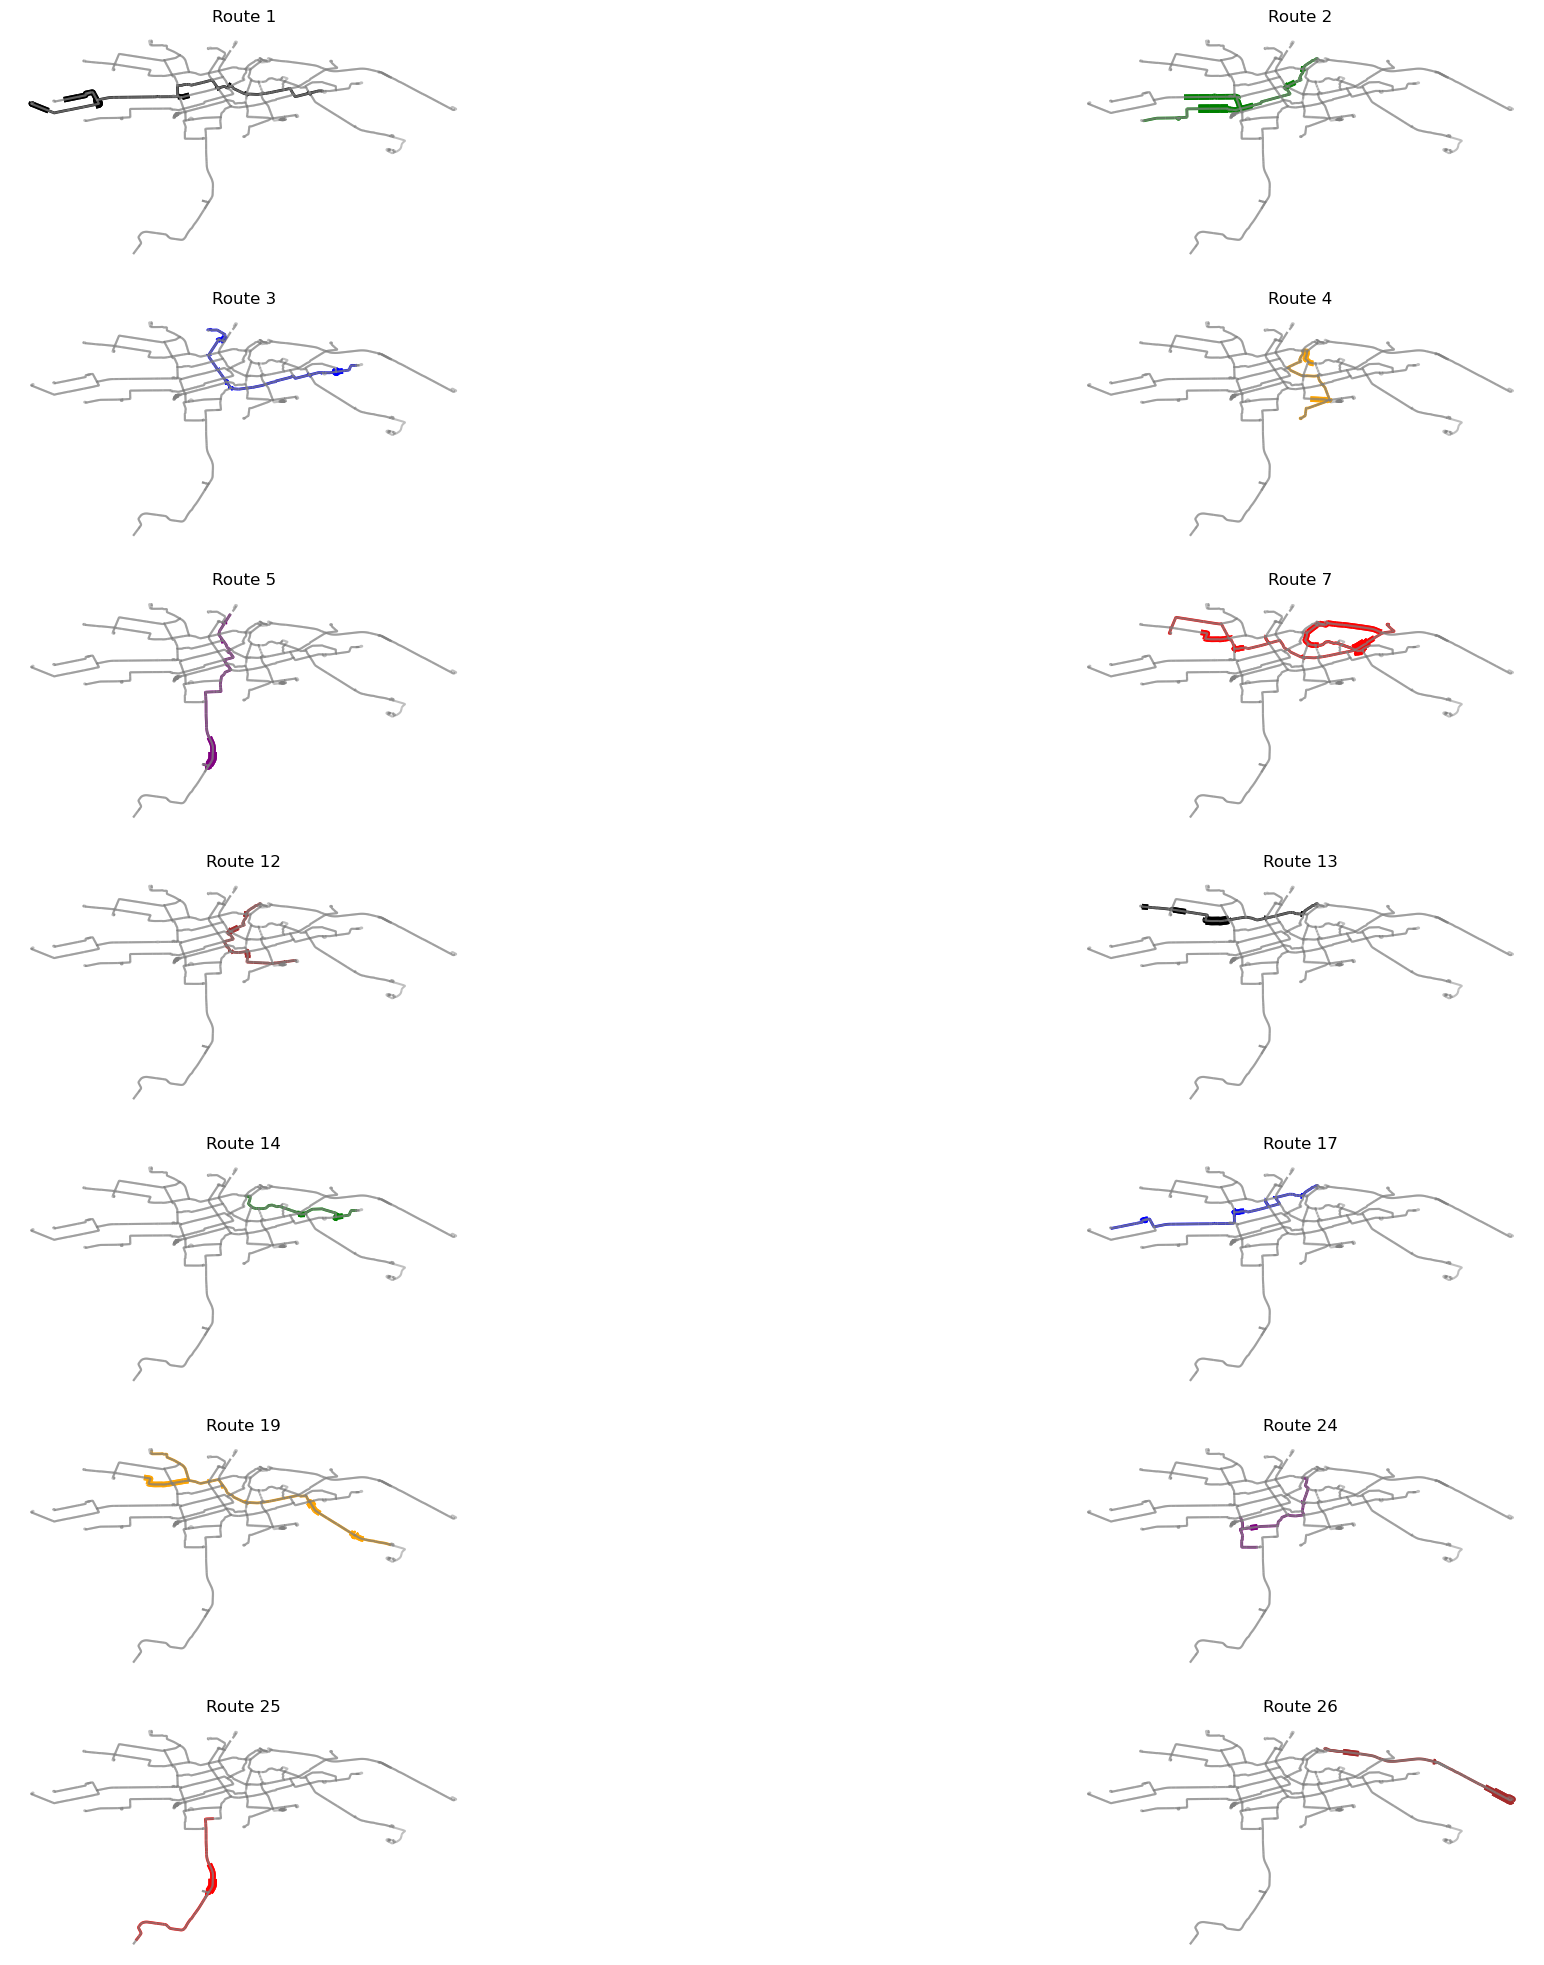

In [30]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))
for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

## Test 2-retrive routes compare with edges - but not working May---try to compare with nodes  June

In [31]:
all_routes = routes(osm_path)
tram_routes = pd.DataFrame(all_routes.loc[all_routes.route == 'tram'])

In [32]:
am_tram_routes = tram_routes.loc[tram_routes.ref != 'EMA']
am_tram_routes['ref'] = am_tram_routes['ref'].astype(int)
am_tram_routes = am_tram_routes.sort_values('ref')
# am_tram_routes

Need to check if the name of real start station is the same to the 'to' column

In [33]:
replacement_dict = {
    ',': '',
    'Diemen': '',
    'Amsterdam': '',
    'Sloterdijk': 'Station Sloterdijk',
    'Osdorp Dijkgraafsplein': 'Dijkgraafplein',
    'Osdorp De Aker': 'Matterhorn'
}

am_tram_routes['to'] = am_tram_routes['to'].replace(replacement_dict, regex=True).str.strip()
am_tram_routes['to'] = am_tram_routes['to'].replace('Amstelveen Westwijk', 'Westwijk').str.strip()
am_tram_routes = am_tram_routes.reset_index(drop=True)
# am_tram_routes

In [34]:
am_tram_start_station_dict = {'am_tram_line1_0':am_tram_routes.iloc[0]['to'],
                     'am_tram_line1_1':am_tram_routes.iloc[1]['to'],
                     'am_tram_line2_0':am_tram_routes.iloc[2]['to'],
                     'am_tram_line2_1':am_tram_routes.iloc[3]['to'],
                     'am_tram_line3_0':am_tram_routes.iloc[4]['to'],
                     'am_tram_line3_1':am_tram_routes.iloc[5]['to'],
                     'am_tram_line4_0':am_tram_routes.iloc[6]['to'],
                     'am_tram_line4_1':am_tram_routes.iloc[7]['to'],
                     'am_tram_line5_0':am_tram_routes.iloc[8]['to'],
                     'am_tram_line5_1':am_tram_routes.iloc[9]['to'],
                     'am_tram_line7_0':am_tram_routes.iloc[10]['to'],
                     'am_tram_line7_1':am_tram_routes.iloc[11]['to'],
                     'am_tram_line12_0':am_tram_routes.iloc[12]['to'],
                     'am_tram_line12_1':am_tram_routes.iloc[13]['to'],
                     'am_tram_line13_0':am_tram_routes.iloc[14]['to'],
                     'am_tram_line13_1':am_tram_routes.iloc[15]['to'],
                     'am_tram_line14_0':am_tram_routes.iloc[16]['to'],
                     'am_tram_line14_1':am_tram_routes.iloc[17]['to'],
                     'am_tram_line17_0':am_tram_routes.iloc[18]['to'],
                     'am_tram_line17_1':am_tram_routes.iloc[19]['to'],
                     'am_tram_line19_0':am_tram_routes.iloc[20]['to'],
                     'am_tram_line19_1':am_tram_routes.iloc[21]['to'],
                     'am_tram_line24_0':am_tram_routes.iloc[22]['to'],
                     'am_tram_line24_1':am_tram_routes.iloc[23]['to'],
                     'am_tram_line25_0':am_tram_routes.iloc[24]['to'],
                     'am_tram_line25_1':am_tram_routes.iloc[25]['to'],
                     'am_tram_line26_0':am_tram_routes.iloc[26]['to'],
                     'am_tram_line26_1':am_tram_routes.iloc[27]['to']}

In [35]:
# am_tram_start_station_dict

In [36]:
am_tram_line_dict = {'am_tram_line1_0':0,
                     'am_tram_line1_1':1,
                     'am_tram_line2_0':2,
                     'am_tram_line2_1':3,
                     'am_tram_line3_0':4,
                     'am_tram_line3_1':5,
                     'am_tram_line4_0':6,
                     'am_tram_line4_1':7,
                     'am_tram_line5_0':8,
                     'am_tram_line5_1':9,
                     'am_tram_line7_0':10,
                     'am_tram_line7_1':11,
                     'am_tram_line12_0':12,
                     'am_tram_line12_1':13,
                     'am_tram_line13_0':14,
                     'am_tram_line13_1':15,
                     'am_tram_line14_0':16,
                     'am_tram_line14_1':17,
                     'am_tram_line17_0':18,
                     'am_tram_line17_1':19,
                     'am_tram_line19_0':20,
                     'am_tram_line19_1':21,
                     'am_tram_line24_0':22,
                     'am_tram_line24_1':23,
                     'am_tram_line25_0':24,
                     'am_tram_line25_1':25,
                     'am_tram_line26_0':26,
                     'am_tram_line26_1':27}

In [37]:
am_all_tram_stations= gpd.GeoDataFrame(am_all_tram_stations.copy())

In [38]:
am_all_tram_stations_name = am_all_tram_stations[['name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
# am_all_tram_stations_name

In [39]:
am_tram_stations_dict = am_tram_line_dict.copy()

for key,value in am_tram_stations_dict.items():
    value1 = value
    value2 = am_all_tram_stations_name.loc[am_all_tram_stations_name.within(am_tram_routes.iloc[value1].geometry.buffer(0.00000001))]
    value2['id'] = value2.reset_index().index
    am_tram_stations_dict[key] = value2[['id', 'name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)

am_tram_stations_dict

{'am_tram_line1_0':     id                              name                  geometry     geo_x  \
 0    0                      Dapperstraat  POINT (4.92894 52.36093)  4.928942   
 1    1                       Rijksmuseum  POINT (4.88710 52.36097)  4.887104   
 2    2                     Surinameplein  POINT (4.85099 52.35807)  4.850994   
 3    3                      Weesperplein  POINT (4.90712 52.36100)  4.907121   
 4    4         Korte 's-Gravesandestraat  POINT (4.91359 52.36235)  4.913592   
 5    5                      Vijzelgracht  POINT (4.89210 52.35951)  4.892102   
 6    6                    Linnaeusstraat  POINT (4.92570 52.36012)  4.925703   
 7    7                         Beukenweg  POINT (4.91674 52.35907)  4.916742   
 8    8                           Pilatus  POINT (4.77710 52.35283)  4.777098   
 9    9                       Inaristraat  POINT (4.78366 52.35020)  4.783658   
 10  10              Rhijnvis Feithstraat  POINT (4.86035 52.35905)  4.860354   
 11  11  

In [40]:
am_tram_stations_inorder_dict = am_tram_line_dict.copy()

for line in am_tram_stations_inorder_dict.keys():
    am_tram_stations_inorder = am_tram_stations_dict[line]
    for i in range(len(am_tram_stations_inorder)):
        if am_tram_stations_inorder.iloc[i]['name'] == am_tram_start_station_dict[line]:
            am_tram_stations_inorder_dict[line] = pd.DataFrame(am_tram_stations_inorder.iloc[i]).T

In [41]:
am_tram_stations_inorder_dict

{'am_tram_line1_0':     id        name                      geometry     geo_x      geo_y
 18  18  Matterhorn  POINT (4.7745043 52.3538687)  4.774504  52.353869,
 'am_tram_line1_1':     id                name                      geometry     geo_x      geo_y
 15  15  Muiderpoortstation  POINT (4.9336328 52.3611749)  4.933633  52.361175,
 'am_tram_line2_0':   id                 name                      geometry     geo_x      geo_y
 3  3  Oudenaardeplantsoen  POINT (4.8041222 52.3450454)  4.804122  52.345045,
 'am_tram_line2_1':     id              name                      geometry     geo_x      geo_y
 20  20  Centraal Station  POINT (4.8993575 52.3783416)  4.899357  52.378342,
 'am_tram_line3_0':   id            name                      geometry     geo_x      geo_y
 9  9  Van Hallstraat  POINT (4.8698541 52.3842644)  4.869854  52.384264,
 'am_tram_line3_1':   id       name                      geometry     geo_x      geo_y
 3  3  Flevopark  POINT (4.9520639 52.3652037)  4.952064 

In [42]:
am_tram_order_route_dict = am_tram_line_dict.copy()

In [43]:
for line in am_tram_order_route_dict.keys():
    
    am_tram_order_route_dict[line] = order_route(am_tram_stations_inorder_dict[line], am_tram_stations_dict[line])

In [44]:
am_tram_order_route_dict

{'am_tram_line1_0':     id                              name                      geometry  \
 0   18                        Matterhorn  POINT (4.7745043 52.3538687)   
 1    8                           Pilatus   POINT (4.7770976 52.352828)   
 2    9                       Inaristraat  POINT (4.7836582 52.3501979)   
 3   15                          Ecuplein  POINT (4.7881582 52.3496935)   
 4   14                   Baden Powellweg  POINT (4.7944986 52.3509515)   
 5   11                          Hoekenes  POINT (4.8018434 52.3524319)   
 6   17                Louis Davidsstraat  POINT (4.8085181 52.3538389)   
 7   19                     Meer en Vaart    POINT (4.8099119 52.35637)   
 8   16                Johan Huizingalaan  POINT (4.8258953 52.3578123)   
 9   20                  Station Lelylaan  POINT (4.8337835 52.3579004)   
 10  12                 Derkinderenstraat  POINT (4.8397482 52.3579573)   
 11   2                     Surinameplein  POINT (4.8509943 52.3580728)   
 12  1

In [45]:
am_tram_order_coordinates = am_tram_order_route_dict.copy()

am_tram_order_coordinates = {key: value[['name', 'geo_x', 'geo_y']] for key, value in am_tram_order_coordinates.items()}

am_tram_order_coordinates

{'am_tram_line1_0':                                 name     geo_x      geo_y
 0                         Matterhorn  4.774504  52.353869
 1                            Pilatus  4.777098  52.352828
 2                        Inaristraat  4.783658  52.350198
 3                           Ecuplein  4.788158  52.349694
 4                    Baden Powellweg  4.794499  52.350952
 5                           Hoekenes  4.801843  52.352432
 6                 Louis Davidsstraat  4.808518  52.353839
 7                      Meer en Vaart  4.809912   52.35637
 8                 Johan Huizingalaan  4.825895  52.357812
 9                   Station Lelylaan  4.833784    52.3579
 10                 Derkinderenstraat  4.839748  52.357957
 11                     Surinameplein  4.850994  52.358073
 12              Rhijnvis Feithstraat  4.860354   52.35905
 13            Jan Pieter Heijestraat  4.865792  52.360364
 14  Eerste Constantijn Huygensstraat  4.874714  52.362616
 15                       Leidseplein

In [46]:
new_dict = {}

for key, value in am_tram_order_coordinates.items():
    shifted_value = pd.concat([value, value.shift(-1)], axis=1)
    shifted_value.columns = [f'col{i+1}' for i in range(len(value.columns))] + [f'col{i+4}' for i in range(len(value.columns))]
    new_dict[key] = shifted_value.dropna().reset_index(drop=True)
# new_dict['am_tram_line5_0']

In [47]:
am_tram_order_coordinates = {key: value[['col1', 'col4', 'col2', 'col3', 'col5', 'col6']] for key, value in new_dict.items()}

In [48]:
for key, value in am_tram_order_coordinates.items():
    
    value.rename(columns={'col1': 's_name', 'col4': 'e_name','col2': 's_coordinates_x', 'col3': 's_coordinates_y', 'col5': 'e_coordinates_x', 'col6': 'e_coordinates_y'}, inplace=True)

In [49]:
# am_tram_order_coordinates['am_tram_line5_0']

In [50]:
am_tram_order_coordinates_pairs = am_tram_order_coordinates.copy()
am_tram_order_id_pairs = am_tram_order_coordinates.copy()

In [51]:
for line in am_tram_order_coordinates.keys():
    am_tram_order_coordinates_pairs[line] = s_e_coordinates_pairs(am_tram_order_coordinates[line])
    am_tram_order_id_pairs[line] = id_pairs(am_tram_order_coordinates_pairs[line],nodes)

In [52]:
# am_tram_order_coordinates_pairs['am_tram_line5_0']

In [53]:
# am_tram_order_id_pairs['am_tram_line5_0']

In [54]:
G = create_ground_graph(edges, nodes)

In [55]:
am_tram_shortest_path_pairs = am_tram_order_id_pairs.copy()
duplicate_row_count = am_tram_order_id_pairs.copy()
am_tram_shortest_path_edges = am_tram_order_id_pairs.copy()
am_tram_edges = am_tram_order_id_pairs.copy()

In [56]:
for line in am_tram_order_id_pairs.keys():
    am_tram_shortest_path_pairs[line] = all_shortest_paths(am_tram_order_id_pairs[line],edges)
    duplicate_row_count[line], am_tram_shortest_path_edges[line], am_tram_edges[line] = edges_with_count_weight(am_tram_shortest_path_pairs[line],edges)

In [57]:
am_tram_shortest_edges_list = list(am_tram_shortest_path_edges.items())

In [58]:
# am_tram_shortest_edges_list

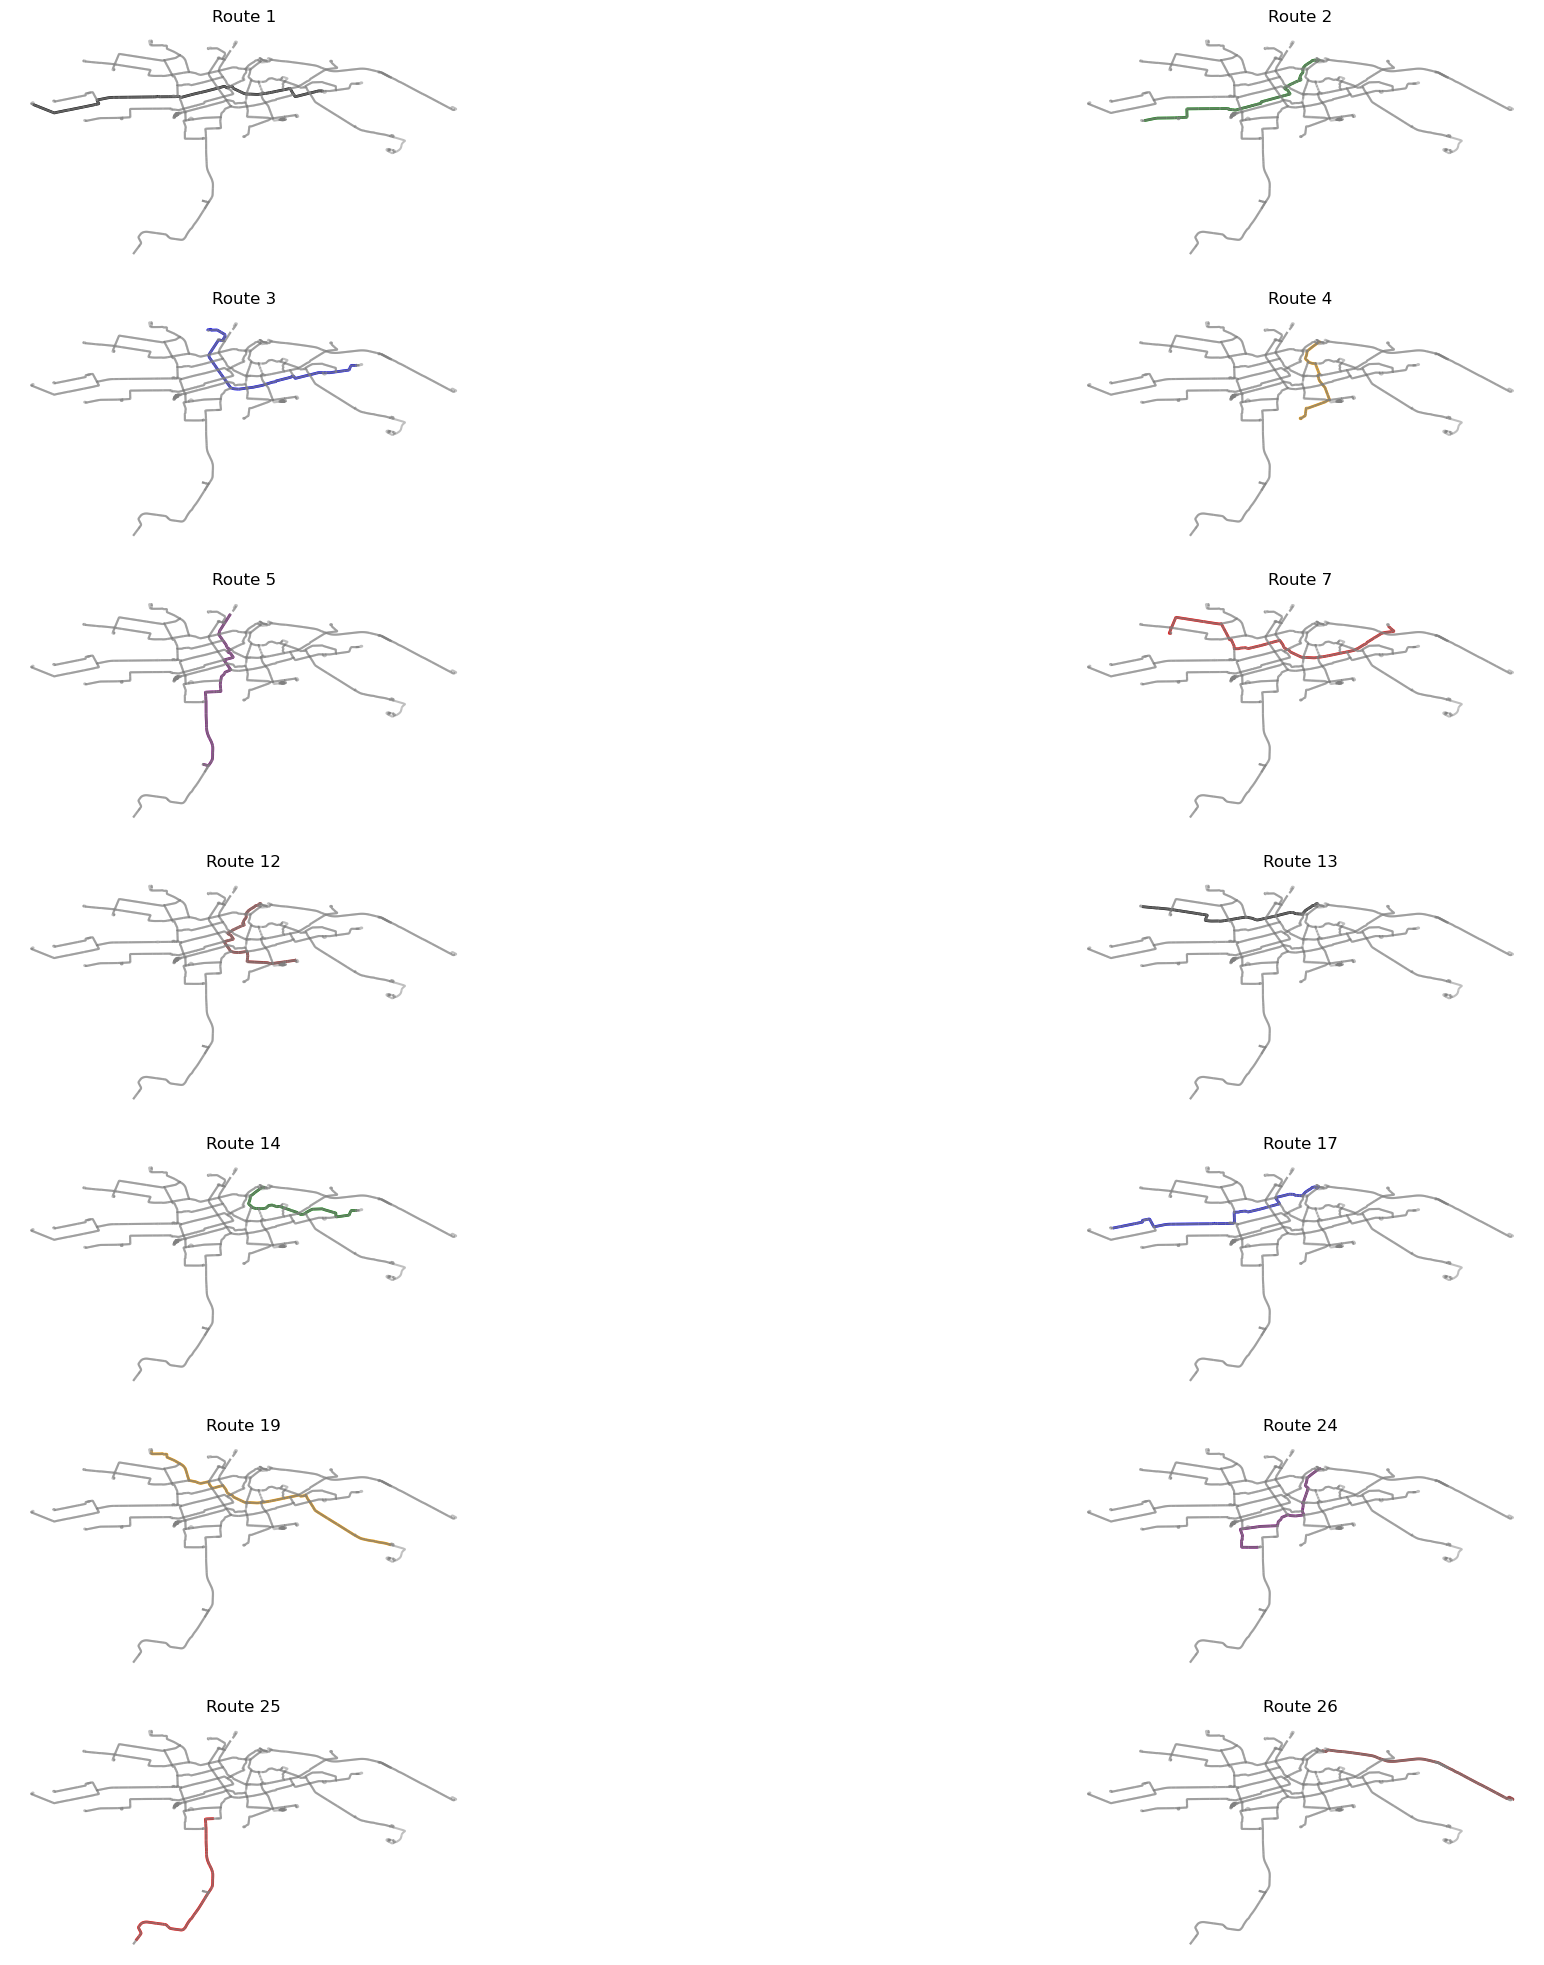

In [59]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))
for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

In [ ]:
# def order_route(first_stop, unordered_route):
#     new_order = []
#     remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)
#     tree = shapely.STRtree(remaining_route.geometry)
#     new_order.append(first_stop)
#     for iter_ in range(len(remaining_route)):
#         try:
#             if iter_ == 0:
#                 nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
#                 new_order.append(nearest_station)
#                 remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
#                 tree = shapely.STRtree(remaining_route.geometry)
#             elif iter_ == 1:
#                 second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
#                 new_order.append(second_station)
#                 remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
#                 tree = shapely.STRtree(remaining_route.geometry)
#             else:
#                 second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
#                 new_order.append(second_station)
#                 remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
#                 tree = shapely.STRtree(remaining_route.geometry)
#         except TypeError:
#             pass  # pass 'NoneType' object is not subscriptable Error
#     return pd.concat(new_order).reset_index(drop=True)

In [ ]:
def order_route(first_stop,unordered_route):

    new_order = []

    remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)
    
    tree = shapely.STRtree(remaining_route.geometry)

    new_order.append(first_stop)
    
    for iter_ in range(len(remaining_route)):
        if iter_ == 0:
            nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
            new_order.append(nearest_station)
            remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
            tree = shapely.STRtree(remaining_route.geometry)
        
        elif iter_ == 1:
            second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
            new_order.append(second_station)
            remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
            tree = shapely.STRtree(remaining_route.geometry)
            print(second_station)
        else:
            second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
            new_order.append(second_station)
            remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
            tree = shapely.STRtree(remaining_route.geometry)

    return pd.concat(new_order).reset_index(drop=True)

In [42]:
first_stop = am_tram_stations_inorder_dict['am_tram_line19_1']
unordered_route = am_tram_stations_dict['am_tram_line19_1']
order_route(first_stop,unordered_route)

[    id   name                      geometry     geo_x     geo_y
 23  23  Sniep  POINT (4.9697229 52.3364299)  4.969723  52.33643,
     id        name                      geometry     geo_x      geo_y
 25  26  Diemerbrug  POINT (4.9613021 52.3382375)  4.961302  52.338237,
     id                name                    geometry     geo_x     geo_y
 13  13  Arent Krijtsstraat  POINT (4.9546574 52.33957)  4.954657  52.33957,
     id         name                      geometry     geo_x      geo_y
 14  15  Brinkstraat  POINT (4.9478959 52.3428971)  4.947896  52.342897,
   id       name                      geometry     geo_x      geo_y
 3  3  Kruislaan  POINT (4.9398853 52.3479273)  4.939885  52.347927,
     id               name                    geometry     geo_x      geo_y
 12  14  Hugo de Vrieslaan  POINT (4.934801 52.351066)  4.934801  52.351066,
     id     name                      geometry     geo_x      geo_y
 21  27  Hogeweg  POINT (4.9310414 52.3534088)  4.931041  52.353409,
 

In [43]:
first_stop = am_tram_stations_inorder_dict['am_tram_line5_0']
unordered_route = am_tram_stations_dict['am_tram_line5_0']
order_route(first_stop,unordered_route)

[    id                  name                      geometry     geo_x  \
 15  15  Amstelveen Stadshart  POINT (4.8671267 52.3013177)  4.867127   
 
         geo_y  
 15  52.301318  ,
   id        name                      geometry     geo_x      geo_y
 2  2  Oranjebaan  POINT (4.8716334 52.3027943)  4.871633  52.302794,
     id      name                      geometry     geo_x     geo_y
 14  16  Onderuit  POINT (4.8724478 52.3079604)  4.872448  52.30796,
     id        name                      geometry     geo_x     geo_y
 17  20  Zonnestein  POINT (4.8723368 52.3114898)  4.872337  52.31149,
     id        name                      geometry     geo_x      geo_y
 16  19  Kronenburg  POINT (4.8706466 52.3156231)  4.870647  52.315623,
   id        name                      geometry     geo_x      geo_y
 6  7  Uilenstede  POINT (4.8691021 52.3212764)  4.869102  52.321276,
   id                 name                      geometry     geo_x      geo_y
 5  6  Van Boshuizenstraat  POINT (4.868

In [44]:
first_stop = am_tram_stations_inorder_dict['am_tram_line26_1']
unordered_route = am_tram_stations_dict['am_tram_line26_1']
order_route(first_stop,unordered_route)

[  id    name                      geometry     geo_x      geo_y
 0  0  IJburg  POINT (5.0049024 52.3511345)  5.004902  52.351135,
   id           name                      geometry     geo_x      geo_y
 7  8  Lumièrestraat  POINT (4.9990167 52.3531807)  4.999017  52.353181,
   id            name                      geometry     geo_x      geo_y
 5  6  Diemerparklaan  POINT (4.9946247 52.3555154)  4.994625  52.355515,
    id              name                      geometry     geo_x    geo_y
 7  10  Vennepluimstraat  POINT (4.9905047 52.3576998)  4.990505  52.3577,
   id           name                      geometry     geo_x      geo_y
 6  9  Steigereiland  POINT (4.9799507 52.3632345)  4.979951  52.363234,
   id            name                    geometry     geo_x      geo_y
 4  5  Bob Haarmslaan  POINT (4.968548 52.369133)  4.968548  52.369133,
   id          name                      geometry     geo_x      geo_y
 3  4  Zuiderzeeweg  POINT (4.9616739 52.3719706)  4.961674  52.37197

In [52]:
first_stop = am_tram_stations_inorder_dict['am_tram_line19_1']
unordered_route = am_tram_stations_dict['am_tram_line19_1']

In [53]:
first_stop

,id,name,geometry,geo_x,geo_y
23,23,Sniep,POINT (4.9697229 52.3364299),4.969723,52.33643


In [54]:
new_order = []

remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)

tree = shapely.STRtree(remaining_route.geometry)

new_order.append(first_stop)

In [55]:
new_order

[    id   name                      geometry     geo_x     geo_y
 23  23  Sniep  POINT (4.9697229 52.3364299)  4.969723  52.33643]

In [56]:
remaining_route

,id,name,geometry,geo_x,geo_y
0,0,Weesperplein,POINT (4.90916 52.36140),4.909158,52.361404
1,1,De Rijpstraat,POINT (4.85772 52.37736),4.857724,52.377356
2,2,Jan van Galenstraat,POINT (4.85864 52.37430),4.858643,52.374300
3,3,Kruislaan,POINT (4.93989 52.34793),4.939885,52.347927
4,4,Elandsgracht,POINT (4.87848 52.36817),4.878480,52.368169
5,5,Leidseplein,POINT (4.88307 52.36347),4.883072,52.363471
6,6,Station Sloterdijk,POINT (4.83922 52.38797),4.839217,52.387970
7,7,Bos en Lommerweg,POINT (4.85528 52.38030),4.855277,52.380301
8,8,Wiltzanghlaan,POINT (4.85223 52.38204),4.852225,52.382044
9,9,Alexanderplein,POINT (4.91961 52.36343),4.919610,52.363434


In [57]:
for iter_ in range(len(remaining_route)):
    if iter_ == 0:
        nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
        new_order.append(nearest_station)
        remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
        tree = shapely.STRtree(remaining_route.geometry)
    
    elif iter_ == 1:
        second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
        new_order.append(second_station)
        remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
        tree = shapely.STRtree(remaining_route.geometry)
        print(second_station)
    else:
        second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
        new_order.append(second_station)
        remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
        tree = shapely.STRtree(remaining_route.geometry)

    id                name                    geometry     geo_x     geo_y
13  13  Arent Krijtsstraat  POINT (4.9546574 52.33957)  4.954657  52.33957


TypeError: 'NoneType' object is not subscriptable

In [58]:
new_order

[    id   name                      geometry     geo_x     geo_y
 23  23  Sniep  POINT (4.9697229 52.3364299)  4.969723  52.33643,
     id        name                      geometry     geo_x      geo_y
 25  26  Diemerbrug  POINT (4.9613021 52.3382375)  4.961302  52.338237,
     id                name                    geometry     geo_x     geo_y
 13  13  Arent Krijtsstraat  POINT (4.9546574 52.33957)  4.954657  52.33957,
     id         name                      geometry     geo_x      geo_y
 14  15  Brinkstraat  POINT (4.9478959 52.3428971)  4.947896  52.342897,
   id       name                      geometry     geo_x      geo_y
 3  3  Kruislaan  POINT (4.9398853 52.3479273)  4.939885  52.347927,
     id               name                    geometry     geo_x      geo_y
 12  14  Hugo de Vrieslaan  POINT (4.934801 52.351066)  4.934801  52.351066,
     id     name                      geometry     geo_x      geo_y
 21  27  Hogeweg  POINT (4.9310414 52.3534088)  4.931041  52.353409,
 

In [144]:
for iter_ in range(len(remaining_route)):
    if iter_ == 0:
        nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
        new_order.append(nearest_station)
        remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
        tree = shapely.STRtree(remaining_route.geometry)
    
    elif iter_ == 1:
        second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
        new_order.append(second_station)
        remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
        tree = shapely.STRtree(remaining_route.geometry)
        print(second_station)
    else:
        second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
        new_order.append(second_station)
        remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
        tree = shapely.STRtree(remaining_route.geometry)

In [145]:
new_order

[    id   name                      geometry     geo_x     geo_y
 23  23  Sniep  POINT (4.9697229 52.3364299)  4.969723  52.33643,
     id        name                      geometry     geo_x      geo_y
 25  26  Diemerbrug  POINT (4.9613021 52.3382375)  4.961302  52.338237,
     id                name                    geometry     geo_x     geo_y
 13  13  Arent Krijtsstraat  POINT (4.9546574 52.33957)  4.954657  52.33957,
     id         name                      geometry     geo_x      geo_y
 14  15  Brinkstraat  POINT (4.9478959 52.3428971)  4.947896  52.342897,
   id       name                      geometry     geo_x      geo_y
 3  3  Kruislaan  POINT (4.9398853 52.3479273)  4.939885  52.347927,
     id               name                    geometry     geo_x      geo_y
 12  14  Hugo de Vrieslaan  POINT (4.934801 52.351066)  4.934801  52.351066,
     id     name                      geometry     geo_x      geo_y
 21  27  Hogeweg  POINT (4.9310414 52.3534088)  4.931041  52.353409,
 

In [184]:
new_order = []

remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)

tree = shapely.STRtree(remaining_route.geometry)

In [185]:
remaining_route

,id,name,geometry,geo_x,geo_y
0,0,Roelof Hartplein,POINT (4.88209 52.35312),4.882087,52.353122
1,1,Marnixplein,POINT (4.87918 52.37859),4.879185,52.378590
2,2,Oranjebaan,POINT (4.87163 52.30279),4.871633,52.302794
3,3,Prinses Irenestraat,POINT (4.87678 52.34262),4.876777,52.342615
4,4,Parnassusweg,POINT (4.86868 52.33821),4.868679,52.338208
5,5,Gerrit van der Veenstraat,POINT (4.87737 52.34922),4.877365,52.349216
6,6,Van Boshuizenstraat,POINT (4.86898 52.32489),4.868976,52.324894
7,7,Uilenstede,POINT (4.86910 52.32128),4.869102,52.321276
8,8,Nieuwe Willemstraat,POINT (4.88096 52.38139),4.880956,52.381394
9,9,Rozengracht,POINT (4.87587 52.37266),4.875866,52.372655


In [186]:
new_order.append(first_stop)
new_order

[    id                  name                      geometry     geo_x  \
 15  15  Amstelveen Stadshart  POINT (4.8671267 52.3013177)  4.867127   
 
         geo_y  
 15  52.301318  ]

In [187]:
nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T

In [188]:
nearest_station

,id,name,geometry,geo_x,geo_y
2,2,Oranjebaan,POINT (4.8716334 52.3027943),4.871633,52.302794


In [189]:
new_order.append(nearest_station)
new_order

[    id                  name                      geometry     geo_x  \
 15  15  Amstelveen Stadshart  POINT (4.8671267 52.3013177)  4.867127   
 
         geo_y  
 15  52.301318  ,
   id        name                      geometry     geo_x      geo_y
 2  2  Oranjebaan  POINT (4.8716334 52.3027943)  4.871633  52.302794]

In [190]:
remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)

In [191]:
tree = shapely.STRtree(remaining_route.geometry)

In [192]:
second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
new_order.append(second_station)
new_order

[    id                  name                      geometry     geo_x  \
 15  15  Amstelveen Stadshart  POINT (4.8671267 52.3013177)  4.867127   
 
         geo_y  
 15  52.301318  ,
   id        name                      geometry     geo_x      geo_y
 2  2  Oranjebaan  POINT (4.8716334 52.3027943)  4.871633  52.302794,
     id      name                      geometry     geo_x     geo_y
 14  16  Onderuit  POINT (4.8724478 52.3079604)  4.872448  52.30796]

In [193]:
second_station

,id,name,geometry,geo_x,geo_y
14,16,Onderuit,POINT (4.8724478 52.3079604),4.872448,52.30796


In [194]:
remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
tree = shapely.STRtree(remaining_route.geometry)

In [195]:
second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T

In [196]:
second_station

,id,name,geometry,geo_x,geo_y
17,20,Zonnestein,POINT (4.8723368 52.3114898),4.872337,52.31149


In [197]:
new_order.append(second_station)
remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
tree = shapely.STRtree(remaining_route.geometry)

In [198]:
new_order

[    id                  name                      geometry     geo_x  \
 15  15  Amstelveen Stadshart  POINT (4.8671267 52.3013177)  4.867127   
 
         geo_y  
 15  52.301318  ,
   id        name                      geometry     geo_x      geo_y
 2  2  Oranjebaan  POINT (4.8716334 52.3027943)  4.871633  52.302794,
     id      name                      geometry     geo_x     geo_y
 14  16  Onderuit  POINT (4.8724478 52.3079604)  4.872448  52.30796,
     id        name                      geometry     geo_x     geo_y
 17  20  Zonnestein  POINT (4.8723368 52.3114898)  4.872337  52.31149]

In [200]:
second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T

In [201]:
second_station

,id,name,geometry,geo_x,geo_y
16,19,Kronenburg,POINT (4.8706466 52.3156231),4.870647,52.315623


### retrive routes compare with edges - but not working May

In [ ]:
tram_routes['each_line'] = tram_routes.geometry.apply(lambda x: [Line for Line in x])
# tram_routes

In [ ]:
edges.geometry = edges.geometry.apply(shapely.to_shapely)  #因为tram_routes中是shapely格式
edges['route'] = ''

In [ ]:
edges

In [ ]:
edges.to_excel('./am_tram_edges.xlsx',header = True, index = False)  
tram_routes.to_excel('./am_tram_routes.xlsx',header = True, index = False)  

In [ ]:
# 将route的ref添加进edges的route列
# 问题可能出在：edges中geometry的linestring部分存在在tram_routes中each_line的multilinestring中， 比如第1005行

In [ ]:
# 方法1
# df_edges=pd.merge(edges,tram_routes,how='left',left_on='geometry',right_on='each_line')
# df_edges=df_edges.loc[:,['osm_id','gemotry','railway','service','id','from_id','to_id','distance','time','weights','to_from','from_to','ref']]
# df31=pd.merge(am_tram_name,am_tram_stations,how='left',left_on='s_name',right_on='name')
# df31=df31.loc[:,['s_name','e_name','geo_x','geo_y']]

In [ ]:
# 方法2
# for n in range(len(tram_routes)):
#     b = gpd.GeoSeries(tram_routes.each_line.iloc[n])
#     for i in range(len(edges)):
#         a = gpd.GeoSeries(edges.geometry.iloc[i])
#         if a.within(b).all():
#             edges.route.iloc[i] = tram_routes.ref.iloc[n]

In [ ]:
# 方法3
#edges['is_on_tram_route'] = edges['geometry'].apply(lambda x: any(x.intersects(route) for route in tram_routes['each_line']))

In [ ]:
#方法4
# for idx, row in edges.iterrows():
#     for each_line in tram_routes.loc['each_line'].tolist():
#         if row['geometry'] in each_line:
#             # 如果第二个表格中的geometry对象在第一个表格中的LineString列表中，则将该行的ref列添加到第二个表格中的对应行中
#             edges.at[idx, 'route'] = tram_routes.loc[tram_routes['each_line'] == each_line, 'ref'].iloc[0]

In [ ]:
for n in range(len(tram_routes)):
    t = 0
    b = tram_routes.each_line.iloc[n]
    t = t + n
    print(t)

In [ ]:
# 方法0
for i in range(len(edges)):
    a = edges.geometry.iloc[i]
    
    for n in range(len(tram_routes)):
        b = tram_routes.each_line.iloc[n]
        c = a in b
        if c > 0:
            edges.route.iloc[i] = tram_routes.ref.iloc[n]      

In [ ]:
#方法0.0
for i in range(len(edges)):
    a = edges.loc[i,'geometry']
    
    for n in range(len(tram_routes)):
        b = tram_routes.iloc[n,tram_routes.columns.get_loc('each_line')]
        if a in b:
            edges.loc[i,'route'] = tram_routes.iloc[n,tram_routes.columns.get_loc('ref')]

In [ ]:
edges

In [ ]:
edges = edges.loc[edges.route != '']
edges

In [ ]:
edges1 = edges.loc[edges.route == '1']
edges1

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


gpd.GeoDataFrame(edges1.copy()).plot(ax=ax,zorder=0)

In [ ]:
a = edges.geometry.loc[0] 
b = tram_routes.each_line.loc[622]
c = tram_routes.each_line.loc[626]

In [ ]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))


# gpd.GeoSeries(a).plot(ax=ax,zorder=0)
# gpd.GeoSeries(b).plot(ax=ax,color='black',zorder=1)
# gpd.GeoSeries(c).plot(ax=ax,color='blue',zorder=2)

In [ ]:
type(a)

In [ ]:
b

In [ ]:
# a = shapely.to_shapely(a)
# a

In [ ]:
a in c

In [ ]:
a in b

In [ ]:
d = edges.geometry.loc[1006]
e = tram_routes.each_line.loc[18]
f = tram_routes.each_line.loc[357]

In [ ]:
d in e

In [ ]:
d in f

In [ ]:
edges.geometry = gpd.GeoDataFrame(edges.copy()).geometry.apply(lambda x: Point(x.coords[0]))
tram_routes.each_line = gpd.GeoDataFrame(tram_routes.copy()).geometry.apply(lambda x: Point(x.coords[0]))

# 对于每个edges的坐标点，判断是否在tram_routes中存在
for index, row in edges.iterrows():
    point = row.geometry
    ref_value = tram_routes[tram_routes.intersects(point)].ref.unique()
    
    # 如果存在，则将ref列的值添加到edges中
    if len(ref_value) > 0:
        edges.at[index, 'ref'] = ref_value[0]

## Test 3-Step 6: find all stations and caculate shortest path between all stations - including Test1-Step2 to Step5

## Test1-Step2: get the coordinates of start-end stations accroding to the station name excel,   
## and then calculate the coordinates_pairs and nearest id pairs of start-end points

In [ ]:
stations = tram_stations(osm_path)

In [ ]:
stations

In [ ]:
stations.to_excel('./am_stations.xlsx',header = True, index = False)  

In [ ]:
am_tram_stations = am_tram_stations(stations)

In [ ]:
am_tram_stations

In [ ]:
am_tram_stations.to_excel('./am_tram_stations.xlsx',header = True, index = False)  

In [ ]:
am_tram_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram_name.xlsx')

In [ ]:
am_tram_coordinates = s_e_tram_coordinates(am_tram_stations, am_tram_name)
am_tram_coordinates

In [ ]:
am_tram_coordinates_pairs = s_e_coordinates_pairs(am_tram_coordinates)

In [ ]:
am_tram_coordinates_pairs

In [ ]:
am_tram_id_pairs = id_pairs(am_tram_coordinates_pairs,nodes)
am_tram_id_pairs

## Test1-Step3: calculate shortest pathes for all id pairs and visulize the tram map with the used time of each edges

In [ ]:
G = create_ground_graph(edges, nodes)

In [ ]:
am_tram_shortest_path_pairs = all_shortest_paths(am_tram_id_pairs,edges)
am_tram_shortest_path_pairs

In [ ]:
duplicate_row_count, am_tram_shortest_path_edges, edges = edges_with_count_weight(am_tram_shortest_path_pairs,edges)
#am_tram_shortest_path_edges, duplicate_row_count

In [ ]:
# am_tram_shortest_path_edges.to_excel('./am_tram_shortest_path_edges.xlsx',header = True, index = False) 

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(am_tram_shortest_path_edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=(am_tram_shortest_path_edges['count_weight'])*2)

In [ ]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=(edges['count_weight'])*2)

## Test1-Step4: draw each route with the base map of Amsterdam tram

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))
for i, ax in enumerate(axes.flat):
    if i < 14:
        route, route_weight, route_edges = shortest_path(G, am_tram_id_pairs.loc[i, 's_id'], am_tram_id_pairs.loc[i, 'e_id'], edges, weight = "weights")
    
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='red')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()

## Test1-Step5: calculate maximum flow for each route of Amsterdam subway

In [ ]:
route_capacity = pd.DataFrame({'metro_num': [5.0, 4.0, 7.0, 6.0, 8.0, 6.0, 9.0, 4.0, 3.0, 5.0, 6.0, 7.0, 5.0, 6.0]})

In [ ]:
edges, route_edges, flow_value_dict, flow_value = max_flow_am_tram(edges, nodes, route_capacity, am_tram_id_pairs, G)

In [ ]:
edges

# Old test records

1 Muiderpoortstation,Matterhorn
2 Centraal Station_B,Oudenaardeplantsoen
3 Flevopark,Van Hallstraat
4 Centraal Station_A,Station RAI
5 Eerste Marnixdwarsstraat,Amstelveen Stadshart
7 Azartplein,Sloterpark
12 Centraal Station_B,Amstelstation
13 Centraal Station_B,Lambertus Zijlplein
14 Centraal Station_A,Flevopark
17 Centraal Station_B,Dijkgraafplein
19 Sniep,Station Sloterdijk
24 Centraal Station_A,De Boelelaan/VU
25 Station Zuid,Westwijk
26 Centraal Station_A,IJburg

## 循环的形式实现am_tram_coordinates_pairs，但是有一个问题，缺失的终点站被起始站坐标补齐，已经解决-因为pbf文件一开始不完整

In [ ]:
am_tram_coordinates_pairs = pd.DataFrame(['s_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y'])
for index, row in am_tram_name.iterrows():
    s_station_name = row['s_name']
    matching_stations1 = am_tram_stations[am_tram_stations['name'] == s_station_name]
    if len(matching_stations1) > 0:
        matching_station = matching_stations1.iloc[0]
        am_tram_coordinates_pairs.loc[index, 's_coordinates_x'] = matching_station['geo_x']
        am_tram_coordinates_pairs.loc[index, 's_coordinates_y'] = matching_station['geo_y'] 

    e_station_name = row['e_name']
    matching_stations2 = am_tram_stations[am_tram_stations['name'] == e_station_name]
    if len(matching_stations2) > 0:
        matching_station = matching_stations2.iloc[0]
        am_tram_coordinates_pairs.loc[index, 'e_coordinates_x'] = matching_station['geo_x']
        am_tram_coordinates_pairs.loc[index, 'e_coordinates_y'] = matching_station['geo_y']


am_tram_coordinates_pairs

## 替代excel文件：am_tram_coordinates  #am_tram_coordinates = pd.read_excel(r'./am_tram_coordinates_pairs.xlsx')

In [ ]:
stations = tram_stations(osm_path)

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(stations.copy()).plot(ax=ax,color='black',zorder=1)

In [ ]:
# stations.to_excel('./am_tram_stations.xlsx',header = True, index = False,sheet_name = 'mydata')  

In [ ]:
stations['geo_x'] = stations.geometry.x
stations['geo_y'] = stations.geometry.y

In [ ]:
sorted_stations = stations.sort_values(by='geo_x')

In [ ]:
stations_drop = sorted_stations [sorted_stations ['name'] != 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
stations_drop

In [ ]:
station_cetralB = sorted_stations[sorted_stations['name'] == 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
station_cetralB.iloc[0, 2] = 'Centraal Station_B'
station_cetralB

In [ ]:
station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
station_cetralA.iloc[0, 2] = 'Centraal Station_A'
station_cetralA

In [ ]:
df_stations_drop = pd.DataFrame(stations_drop)
df_station_cetralB = pd.DataFrame(station_cetralB)
df_station_cetralA = pd.DataFrame(station_cetralA)
am_tram_stations = pd.concat([df_stations_drop, df_station_cetralB, df_station_cetralA])
am_tram_stations

In [ ]:
am_tram_stations = am_tram_stations.sort_values(by='geo_y')
am_tram_stations

In [ ]:
am_tram_name = pd.read_excel(r'./am_tram_name.xlsx')

In [ ]:
am_tram_name

In [ ]:
df31=pd.merge(am_tram_name,am_tram_stations,how='left',left_on='s_name',right_on='name')
df31=df31.loc[:,['s_name','e_name','geo_x','geo_y']]
df32=pd.merge(df31,am_tram_stations,how='left',left_on='e_name',right_on='name')
df32.loc[:,['s_name','e_name','geo_x_x','geo_y_x','geo_x_y','geo_y_y']]

# df32=pd.merge(am_tram_name,am_tram_stations,how='inner',left_on='e_name',right_on='name')
# df32=df32.loc[:,['e_name','geo_x','geo_y']]
# df3=pd.concat([df31,df32])

In [ ]:
am_tram_coordinates = pd.DataFrame()
am_tram_coordinates = df32.loc[:,['s_name','e_name','geo_x_x','geo_y_x','geo_x_y','geo_y_y']]
am_tram_coordinates.columns = ['s_name','e_name','s_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y']

In [ ]:
am_tram_coordinates

In [ ]:
# after using the Amsterdam.bbbike.pbf, there is no need to do this
# am_tram_coordinates.loc[12,'e_coordinates_x'] = 4.8310348
# am_tram_coordinates.loc[12,'e_coordinates_y'] = 52.2748113
# am_tram_coordinates   